In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from monty.serialization import loadfn
from arcs.setup_functions import GraphGenerator

In [3]:
graph = GraphGenerator().from_file(filename='../tests/test_dft_data.json',temperature=100,pressure=1)

/Users/badw/github-projects/arcs/arcs/setup_functions.py:256: RuntimeWarning: overflow encountered in exp
  K = np.exp(


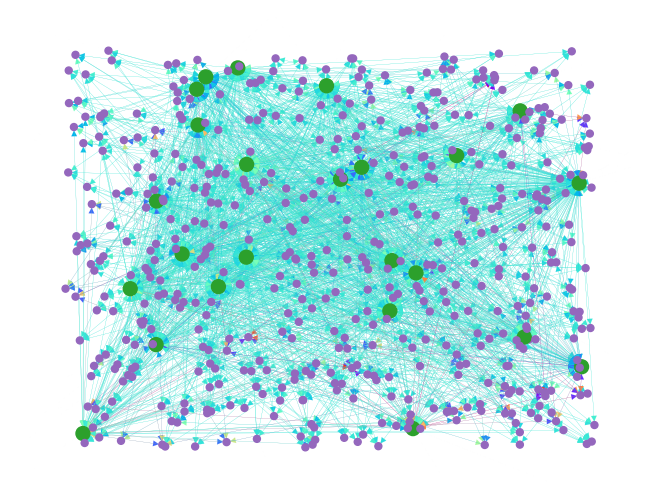

In [ ]:
G = graph 
import matplotlib.pyplot as plt

import networkx as nx 

node_colours= []
node_sizes = []
for node in list(G.nodes):
    if isinstance(node,int):
        node_colours.append('tab:purple')
        node_sizes.append(25)
    else:
        node_colours.append('tab:green')
        node_sizes.append(100)

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

nx.draw_random(G,node_color=node_colours,node_size=node_sizes,edgelist=edges,edge_color=weights,width=0.1,edge_cmap=plt.cm.magma)